# Barrel Cortex Electrophysiology during Tactile VR Navigation

This notebook explores data from [DANDI:001341](https://neurosift.app/dandiset/001341) which contains electrophysiology recordings from the C2 barrel column of wS1 (whisker primary somatosensory cortex) in mice during virtual reality navigation.

## Experiment Overview
- Mice are head-fixed on a suspended ball with two walls placed on either side
- The walls move laterally in closed-loop with the mouse's movement
- Trials consist of:
  1. 100cm straight running baseline (closed-loop)
  2. 2-second open-loop turn to either left (contralateral) or right (ipsilateral)
- No rewards are given (unrewarded 2AFC task)
- Neural activity is recorded from the C2 barrel column

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pynwb
import lindi

# Helper function to load the NWB file
def load_nwb(asset_id):
    url = f"https://lindi.neurosift.org/dandi/dandisets/001341/assets/{asset_id}/nwb.lindi.json"
    f = lindi.LindiH5pyFile.from_lindi_file(url)
    return pynwb.NWBHDF5IO(file=f, mode='r').read()

# Load the first subject's data
nwb = load_nwb('e3d421c3-13bf-4b2e-b0f9-b6357a885de9')

## Subject Information
Let's look at the subject metadata first:

In [3]:
print(f"Subject ID: {nwb.subject.subject_id}")
print(f"Age: {nwb.subject.age}")
print(f"Sex: {nwb.subject.sex}")
print(f"Genotype: {nwb.subject.genotype}")
print(f"Species: {nwb.subject.species}")

Subject ID: 489
Age: P63D
Sex: F
Genotype: Scnn1a-TG3-Cre x Ai32
Species: Mus musculus


## Trial Structure Analysis

The trials table contains information about each trial including start and stop times.
Note: Due to an issue with the stop_time column, we use file_start_time and file_stop_time instead.

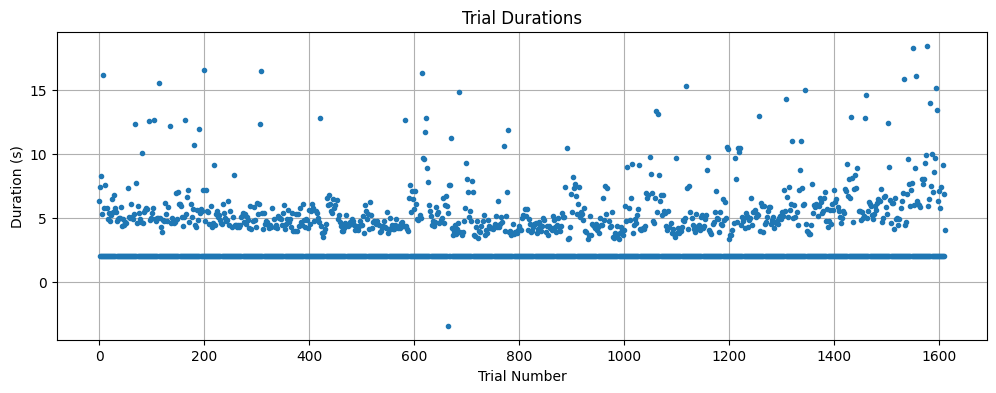

Number of trials: 1611
Mean trial duration: 3.86 seconds
Total experiment duration: 103.9 minutes


In [4]:
trials = nwb.intervals["trials"]

# Load all trials data (relatively small)
trial_starts = trials["file_start_time"][:]
trial_stops = trials["file_stop_time"][:]
trial_durations = trial_stops - trial_starts

# Plot trial durations
plt.figure(figsize=(12, 4))
plt.plot(trial_durations, '.')
plt.xlabel('Trial Number')
plt.ylabel('Duration (s)')
plt.title('Trial Durations')
plt.grid(True)
plt.show()

print(f"Number of trials: {len(trial_durations)}")
print(f"Mean trial duration: {np.mean(trial_durations):.2f} seconds")
print(f"Total experiment duration: {(trial_stops[-1] - trial_starts[0])/60:.1f} minutes")

## Behavioral Data

The dataset includes several behavioral measurements including:
- Forward and lateral speeds/distances
- Position in the virtual corridor

Let's look at an example trial using the first 1000 timepoints:

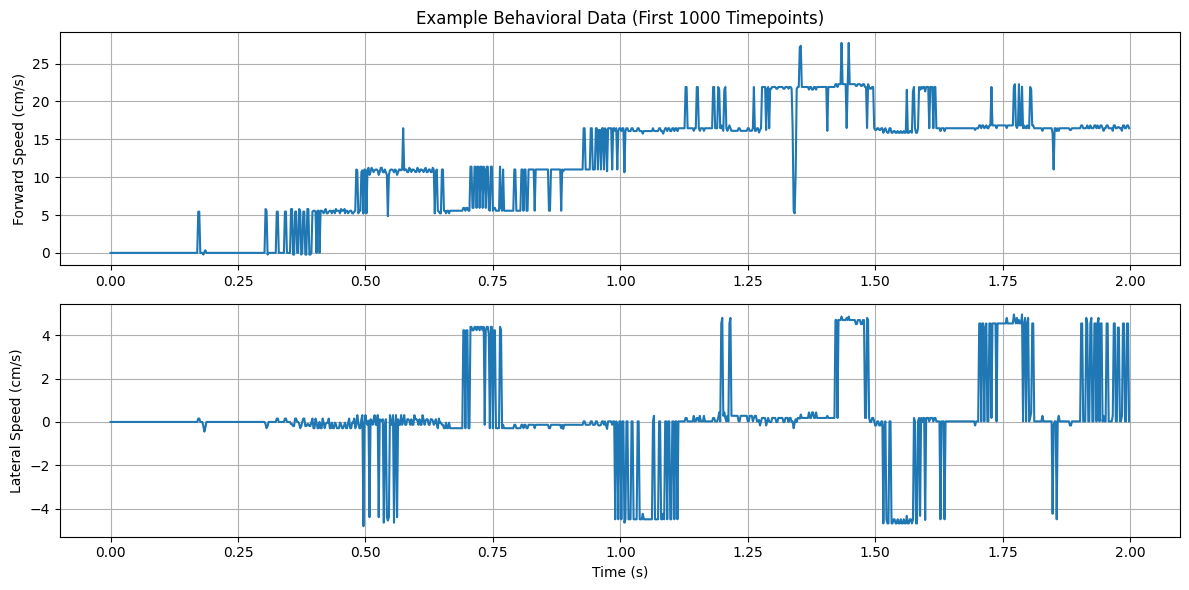

In [5]:
# Get speed data for first 1000 timepoints
speed_for = nwb.acquisition["speed_for"]
speed_lat = nwb.acquisition["speed_lat"]
n_points = 1000

timestamps = speed_for.timestamps[0:n_points]
forward_speed = speed_for.data[0:n_points]
lateral_speed = speed_lat.data[0:n_points]

# Plot speeds
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(timestamps, forward_speed)
plt.ylabel('Forward Speed (cm/s)')
plt.title('Example Behavioral Data (First 1000 Timepoints)')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(timestamps, lateral_speed)
plt.xlabel('Time (s)')
plt.ylabel('Lateral Speed (cm/s)')
plt.grid(True)
plt.tight_layout()
plt.show()

## Neural Data

The dataset contains sorted units from the C2 barrel column. Let's examine their quality metrics:

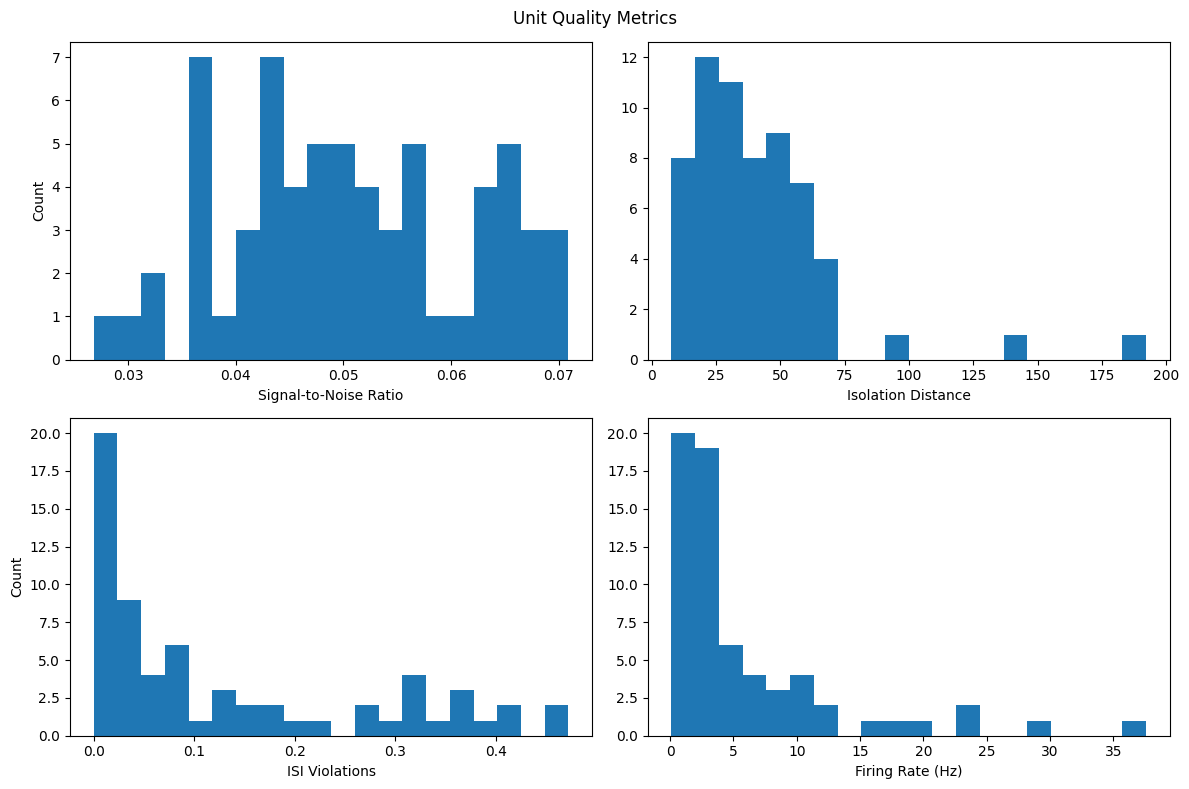

Number of units: 65
Mean firing rate: 6.0 Hz
Mean SNR: 0.1


In [6]:
units = nwb.units

# Get quality metrics
snr = units["snr"][:]
isolation = units["isolation_distance"][:]
isi_violations = units["isi_viol"][:]
firing_rates = units["firing_rate"][:]

# Plot quality metrics
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Unit Quality Metrics')

axs[0,0].hist(snr, bins=20)
axs[0,0].set_xlabel('Signal-to-Noise Ratio')
axs[0,0].set_ylabel('Count')

axs[0,1].hist(isolation, bins=20)
axs[0,1].set_xlabel('Isolation Distance')

axs[1,0].hist(isi_violations, bins=20)
axs[1,0].set_xlabel('ISI Violations')
axs[1,0].set_ylabel('Count')

axs[1,1].hist(firing_rates, bins=20)
axs[1,1].set_xlabel('Firing Rate (Hz)')

plt.tight_layout()
plt.show()

print(f"Number of units: {len(snr)}")
print(f"Mean firing rate: {np.mean(firing_rates):.1f} Hz")
print(f"Mean SNR: {np.mean(snr):.1f}")

## Example PSTH

Let's create a Peri-Stimulus Time Histogram (PSTH) for a single unit around trial starts.
We'll look at spikes in a window around the start of each trial.

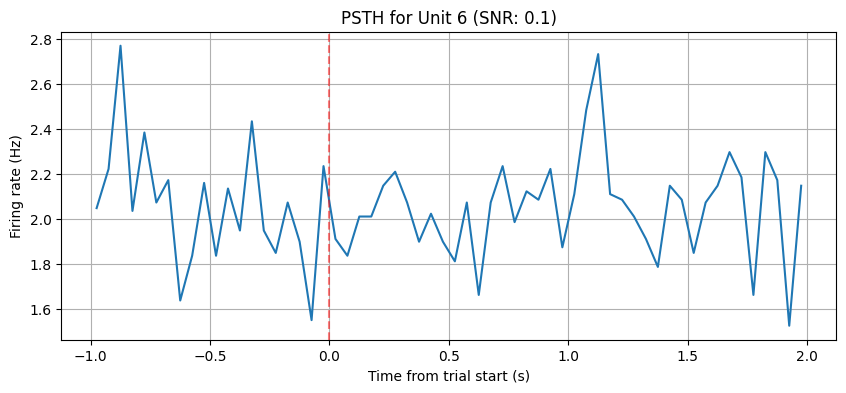

In [7]:
# Select a unit with good metrics
unit_idx = np.argmax(snr)  # Use the unit with highest SNR
spike_times = units["spike_times"][unit_idx]

# Parameters for PSTH
window = [-1, 2]  # 1 second before to 2 seconds after trial start
bin_size = 0.05  # 50ms bins

# Create bins
bins = np.arange(window[0], window[1] + bin_size, bin_size)
bin_centers = bins[:-1] + bin_size/2

# Initialize array to store spike counts
psth = np.zeros((len(trial_starts), len(bins)-1))

# Compute PSTH
for i, start_time in enumerate(trial_starts):
    # Find spikes in window around trial start
    mask = (spike_times >= start_time + window[0]) & (spike_times < start_time + window[1])
    trial_spikes = spike_times[mask] - start_time

    # Bin the spikes
    hist, _ = np.histogram(trial_spikes, bins=bins)
    psth[i] = hist

# Convert to firing rate
firing_rate = psth.mean(axis=0) / bin_size

# Plot PSTH
plt.figure(figsize=(10, 4))
plt.plot(bin_centers, firing_rate)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Time from trial start (s)')
plt.ylabel('Firing rate (Hz)')
plt.title(f'PSTH for Unit {unit_idx} (SNR: {snr[unit_idx]:.1f})')
plt.grid(True)
plt.show()

This PSTH shows how the selected unit's firing rate changes around the start of trials. The red dashed line indicates trial start time (t=0).

Note that this is just one example analysis. The dataset contains rich behavioral and neural data that can be used to investigate:
- Neural responses to different turn directions
- Relationships between speed/position and firing rates
- Population-level analyses across all units
- And much more!